In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
import seaborn as sns
import dask.array as da
import dask.dataframe as ddf
import joypy
import cartopy.crs as ccrs

In [2]:
#open dataset
dm_tprime_xr = xr.open_dataset('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020.nc4')
# tprime_xr = xr.open_dataset('/project2/geos39650/jet_stream/data/t_prime_test_blobs_no_resample_2015-12-01_2020-03-01.nc4')
dm_tprime_xr

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 3429)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2018-02-28
    dayofyear  (time) int64 ...
Data variables:
    t_prime    (time, latitude, longitude) float64 ...

## Hovmoller

In [10]:
def hovmoller(data,lat_range):
    data_strip = data.sel({'latitude': lat_range, 'time':selected_dates})
    meaned_data_strip = data_strip.mean(dim=['latitude']).reset_coords('dayofyear',drop=True)
    meaned_data_strip.to_array().plot()
    plt.title(r"$T'$ at Latitude $\sim 40 ^\circ$ in Winter 2016")

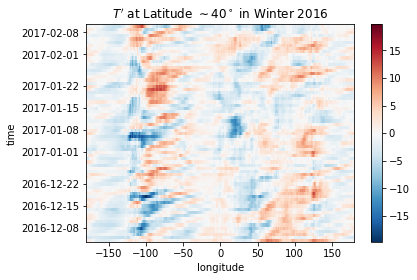

In [11]:
#some grooming
    #select only 10 weeks in the winter of 2016
weeks = 10
period = weeks*7-1
selected_dates= pd.date_range('2016-12-04',periods=period,freq='D')
dm_tprime_xr=dm_tprime_xr.sel(time=selected_dates)
    #re-assign longitudes to make them more intuitive for people
dm_tprime_xr = dm_tprime_xr.assign_coords(longitude=(((dm_tprime_xr.longitude + 180) % 360) - 180)).sortby('longitude')

#choose a latitude range where a lot of people live, like near chi-town
lat_range = np.arange(40,45.25,0.25)

#and plot!
hovmoller(dm_tprime_xr,lat_range)

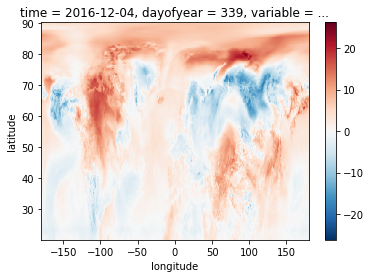

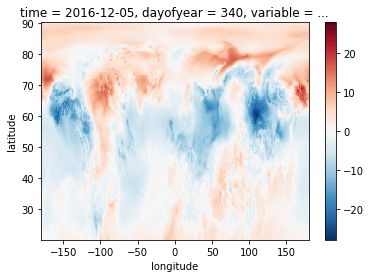

In [5]:
#look at whole available surface for one day, for reference
dm_tprime_xr.isel(time=0).to_array().plot()
plt.show()
dm_tprime_xr.isel(time=1).to_array().plot()

## Joy division

In [25]:
def group_into_winters(dates): #untested
    year_arr = np.zeros(len(dates),dtype=int)
    y=0
    for date in dates:
        if date.month < 3:
            year_arr[y] = date.year - 1
        else:
            year_arr[y] = date.year
        y+=1
    return year_arr

def joy_div(data,data_key='t_prime',decade=False):
    ''' accepts a dataframe and make a joy division plot of successive distributions in data_key. 
     If decade=False, these distributions are calculated yearly. If True, they are calculated every 10 years'''
            
    data['year'] = group_into_winters(data.index)
    time_key='year'
    if decade:
        time_key='decade'
        data['decade'] = data.year.apply(lambda x: int(x)//10 * 10)
    data_filter = data.filter([time_key,data_key])
    
    labels=[y if y%5==0 else None for y in list(data[time_key].unique())]
    fig, axes = joypy.joyplot(data_df_chi, 
                          by=time_key,
                              labels=labels,
                              grid='y',
                              linewidth=1,
                          column=data_key,
                          fade=True,
                          figsize=(5, 6))
    plt.xlabel("T' [K]")
    plt.ylabel("year")
    plt.show()
    return data_filter

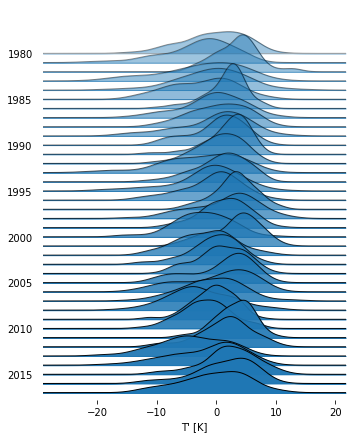

,year,t_prime
time,,
1980-12-01,1980,2.262002
1980-12-02,1980,3.391371
1980-12-03,1980,-2.898141
1980-12-04,1980,-2.111960
1980-12-05,1980,4.555823
...,...,...
2018-02-24,2017,3.644279
2018-02-25,2017,4.426621
2018-02-26,2017,3.188130


In [26]:
#choose a location
data_xr_chi = dm_tprime_xr.sel({'longitude': 272.5, 'latitude':42.0})
#now get rid of those extraeous location coords
data_xr_chi=data_xr_chi.reset_coords(['longitude', 'latitude'],drop=True)

#make it a dataframe for easier handling with joypy
data_df_chi = data_xr_chi.to_dataframe()
joy_div(data_df_chi)

## Overlayed KDEs

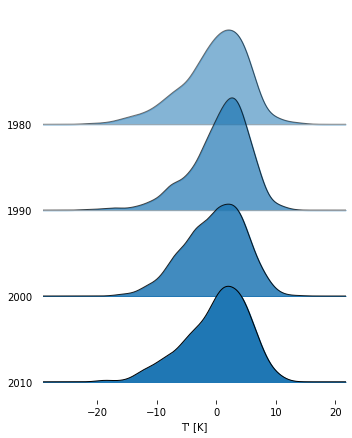

In [27]:
decadal_data = joy_div(data_df_chi,data_key='t_prime',decade=True)

In [28]:
def overlayed_decades(data,year,clr='blue'):
    data_in_decade = data.loc[(data['decade']==year),'t_prime']
    sns.kdeplot(data_in_decade, shade=True, alpha=0.3, Label=str(year)+'s',color=clr)
    quantiles = np.quantile(data_in_decade,[0.1,0.9])
    plt.axvline(quantiles[0],color=clr,linestyle='--',alpha=0.5)
    plt.axvline(quantiles[1],color=clr,linestyle='--',alpha=0.5)

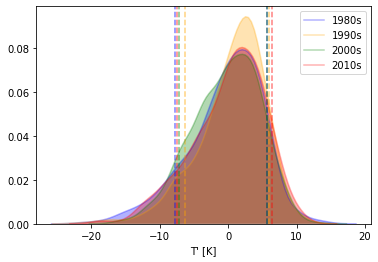

In [30]:
overlayed_decades(decadal_data,1980,'blue')
overlayed_decades(decadal_data,1990,'orange')
overlayed_decades(decadal_data,2000,'green')
overlayed_decades(decadal_data,2010,'red')
plt.xlabel("T' [K]")
plt.show()

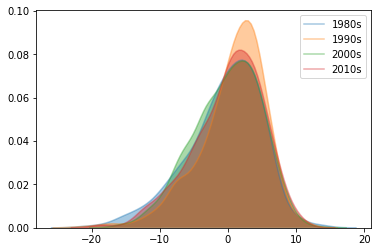

In [33]:
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==1980),'t_prime'], shade=True, alpha=0.4, Label='1980s')
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==1990),'t_prime'], shade=True, alpha=0.4, Label='1990s') 
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==2000),'t_prime'], shade=True, alpha=0.4, Label='2000s') 
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==2010),'t_prime'], shade=True, alpha=0.4, Label='2010s') 